I set up a process to collect real-time data, the python script runs in the digital ocean server, which will include both mempool and block information. While I am gathering this data over time, I will initially focus on building models using only history_data_history1.csv. Once I have collected sufficient real-time mempool data, I will update and refine the models to incorporate the additional features from the mempool. for the history_data_history1.csv, I have following plan.

1. Using the full Dataset for EDA and Model Building:

Since bitcoin_data_history1.csv contains consecutive time-collected data with both mempool and block information, we can use it for a more complete model. By including mempool data, our model may capture more dynamic features of the network, such as mempool size, transaction count, and fee rates, which could improve predictive performance. Cleaning the dataset and performing exploratory data analysis (EDA) will allow you to identify any patterns, correlations, or outliers before building your model.

2. Comparison with Block-Only Dataset:

Comparing the performance of a model trained on both mempool and block information with a model trained on block information alone is a solid approach. This will help us assess the added value of including mempool data:

Block-Only Data: This will provide a baseline performance. Block-level features are more stable and predictable.
Block + Mempool Data: By including mempool data, we may improve the model’s ability to predict short-term changes (like fee rates) because mempool information captures network congestion and transaction dynamics that block data alone might miss.

3. Model Performance Comparison:

we can compare the two datasets using standard metrics like RMSE, MAE, or R² (depending on the type of model we're building). This will give us insights into whether the additional real-time data from the mempool contributes meaningfully to your predictions.

4. Next Steps:

Model Building: Build models on both the full dataset (block + mempool info) and block-only dataset, and compare their performance.

In [1]:
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [15]:
df = pd.read_csv('bitcoin_data_history1.csv')

In [16]:
# Convert 'block_time' to datetime
df['block_time'] = pd.to_datetime(df['block_time'], unit='s')

# Set 'block_time' as index
df.set_index('block_time', inplace=True)

In [17]:

def plot_boxplots(df, title):
    n_cols = len(df.columns)
    n_rows = (n_cols + 3) // 4  
    
    plt.figure(figsize=(20, 5 * n_rows))
    for i, column in enumerate(df.columns):
        plt.subplot(n_rows, 4, i+1)
        sns.boxplot(y=df[column])
        plt.title(column)
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

Original data shape: (26700, 21)
Removed 0 duplicate rows.

Columns with NaN values:
block_interval            1
block_median_fee_rate    79
dtype: int64
No NaN values found after handling.


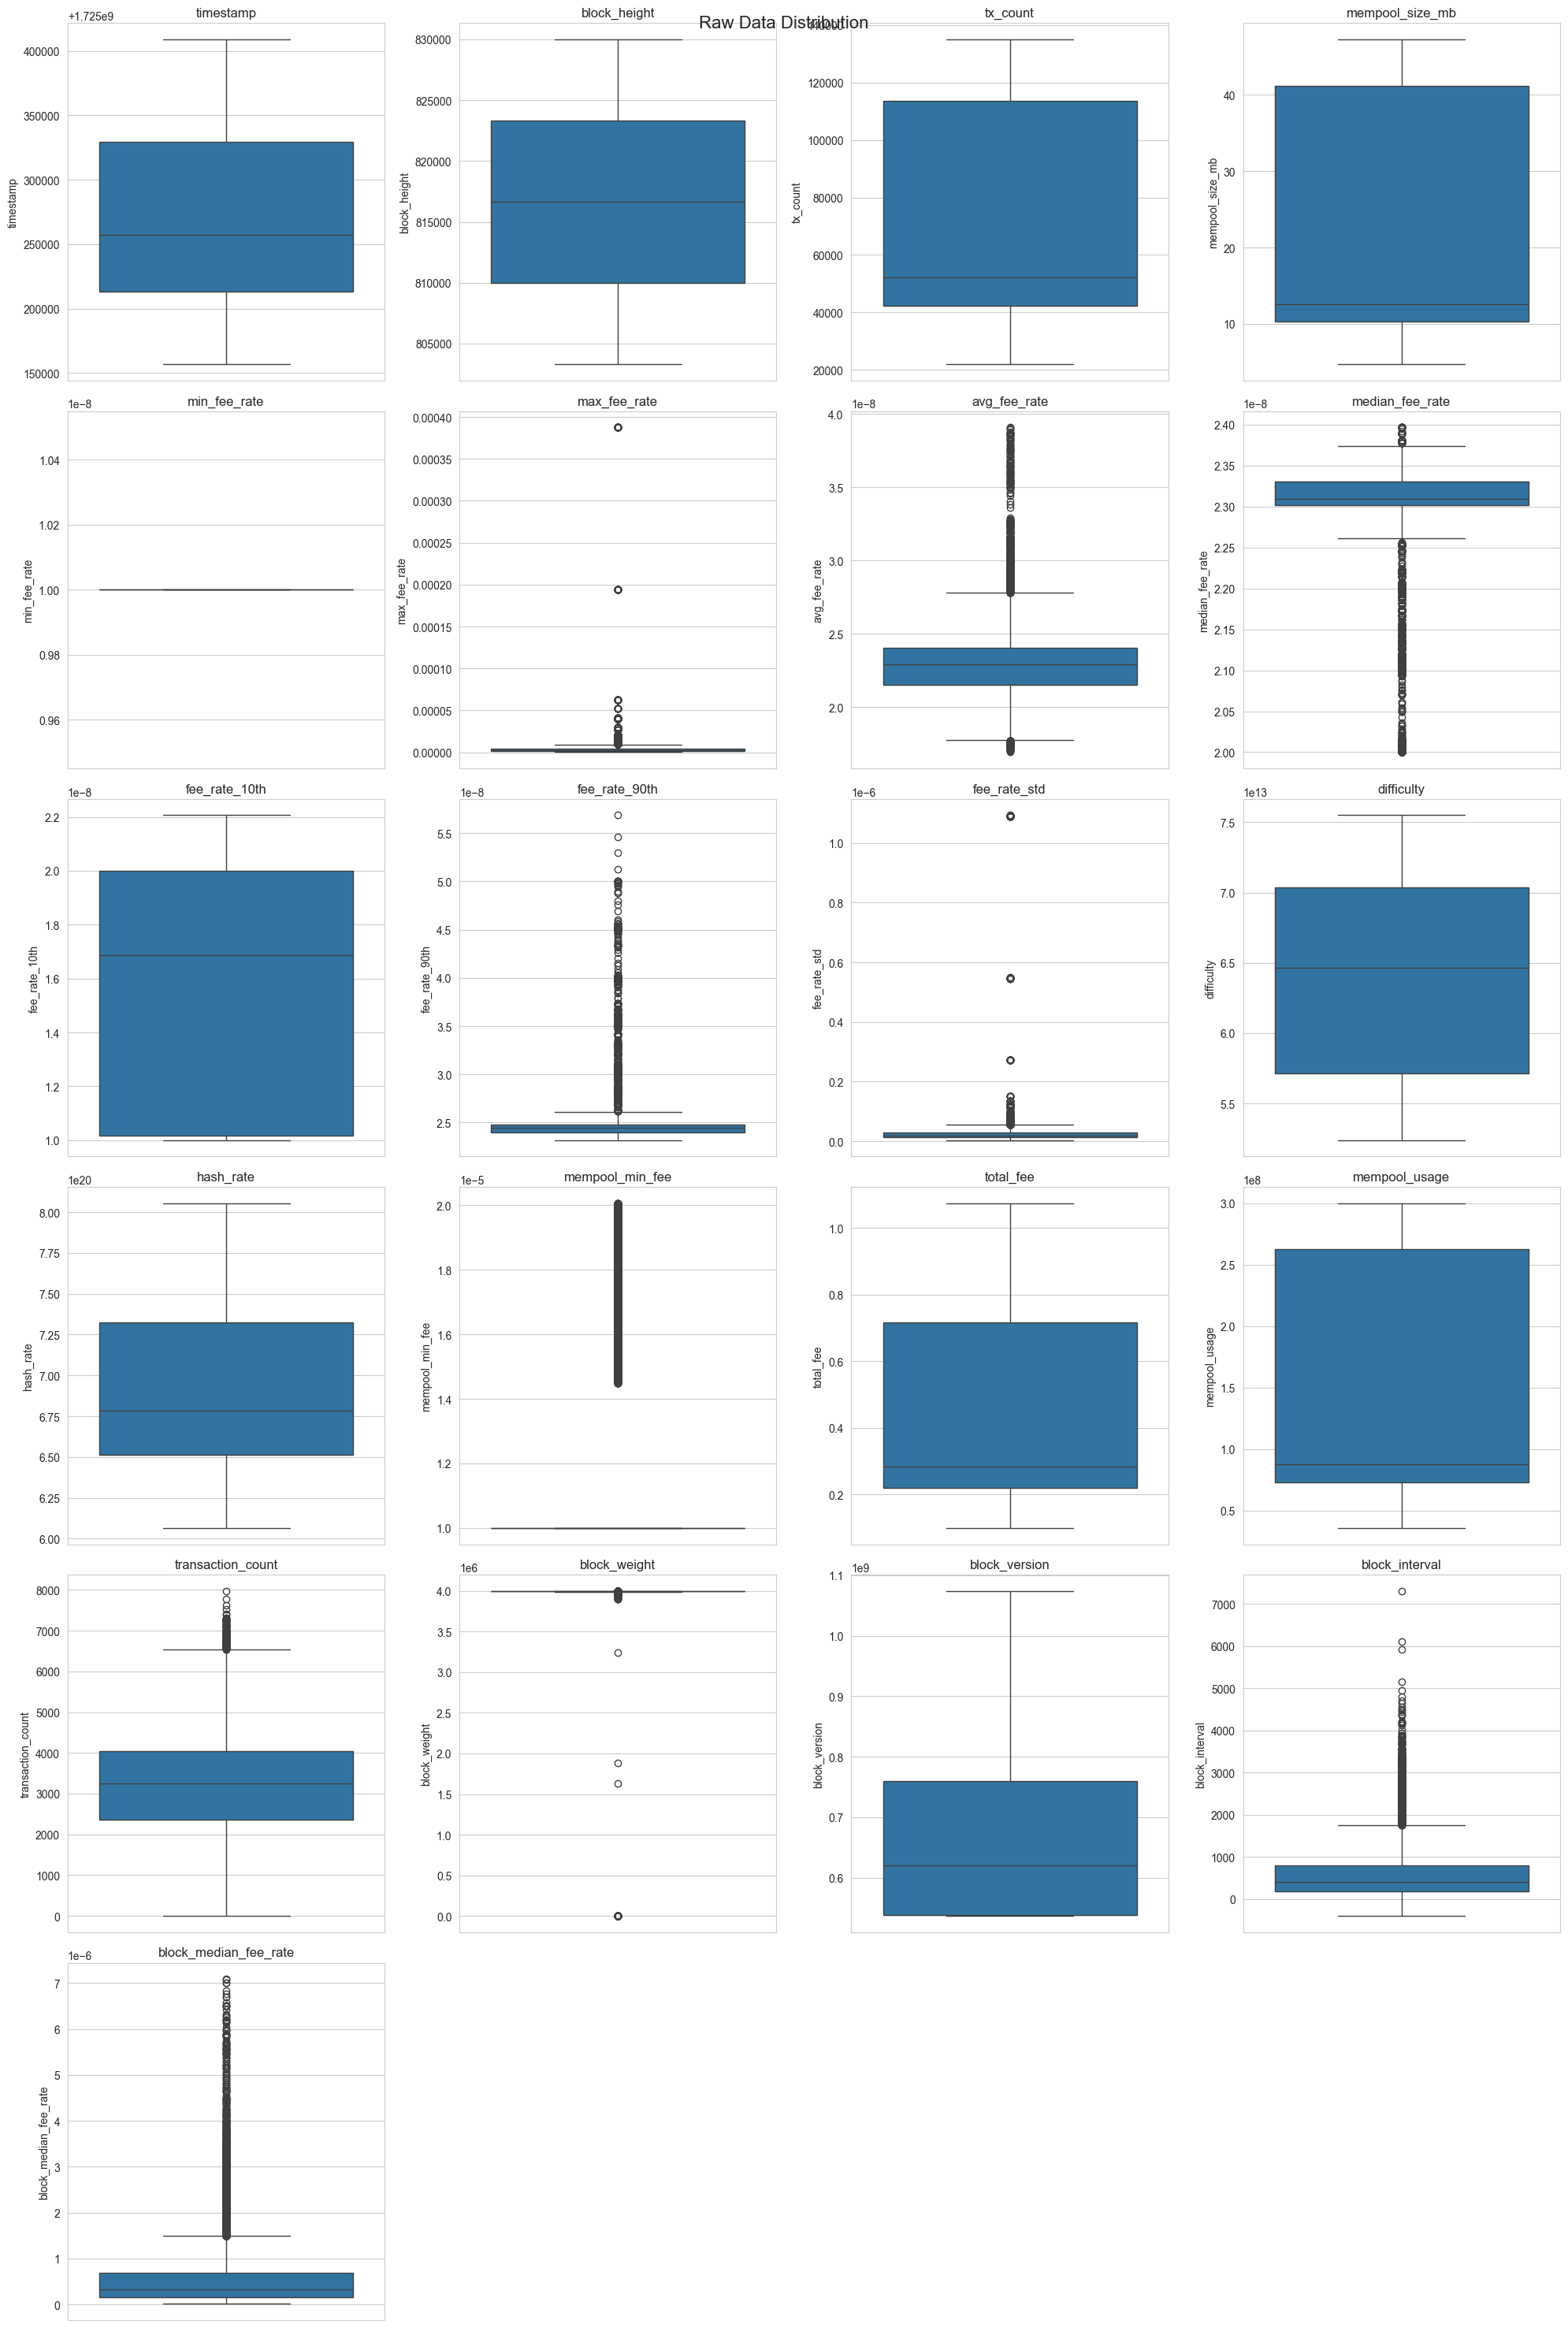

In [18]:
print("Original data shape:", df.shape)

duplicates = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Removed {duplicates} duplicate rows.")

nan_counts = df.isna().sum()
columns_with_nan = nan_counts[nan_counts > 0]
if not columns_with_nan.empty:
    print("\nColumns with NaN values:")
    print(columns_with_nan)
    
    # Handle NaN values
    median_interval = df['block_interval'].median()  # Calculate median interval once
    for column in columns_with_nan.index:
        if column == 'block_interval':
            # For the first row, use the median interval. For others, forward fill.
            df['block_interval'] = df['block_interval'].ffill().fillna(median_interval)
        elif column == 'block_median_fee_rate':
            # Use forward fill, then backward fill for any remaining NaNs
            df[column] = df[column].ffill().bfill()
        elif column in ['mempool_size_mb', 'tx_count', 'mempool_usage']:
            # For mempool-related metrics, 0 might be appropriate if the mempool was empty
            df[column] = df[column].fillna(0)
        else:
            # For other columns, use forward fill, then backward fill
            df[column] = df[column].ffill().bfill()

    remaining_nans = df.isna().sum()[df.isna().sum() > 0]
    if not remaining_nans.empty:
        print("\nRemaining NaN values after handling:")
        print(remaining_nans)
    else:
        print("No NaN values found after handling.")
else:
    print("No NaN values found.")

# If there are still any NaN values, drop those rows
rows_before = df.shape[0]
df = df.dropna()
rows_after = df.shape[0]
if rows_before > rows_after:
    print(f"\nDropped {rows_before - rows_after} rows with remaining NaN values.")


if df.empty:
    print("Warning: DataFrame is empty after cleaning. Please check the data processing steps.")
else:
    # Plotting the distribution of the cleaned data
    plot_boxplots(df, "Raw Data Distribution")


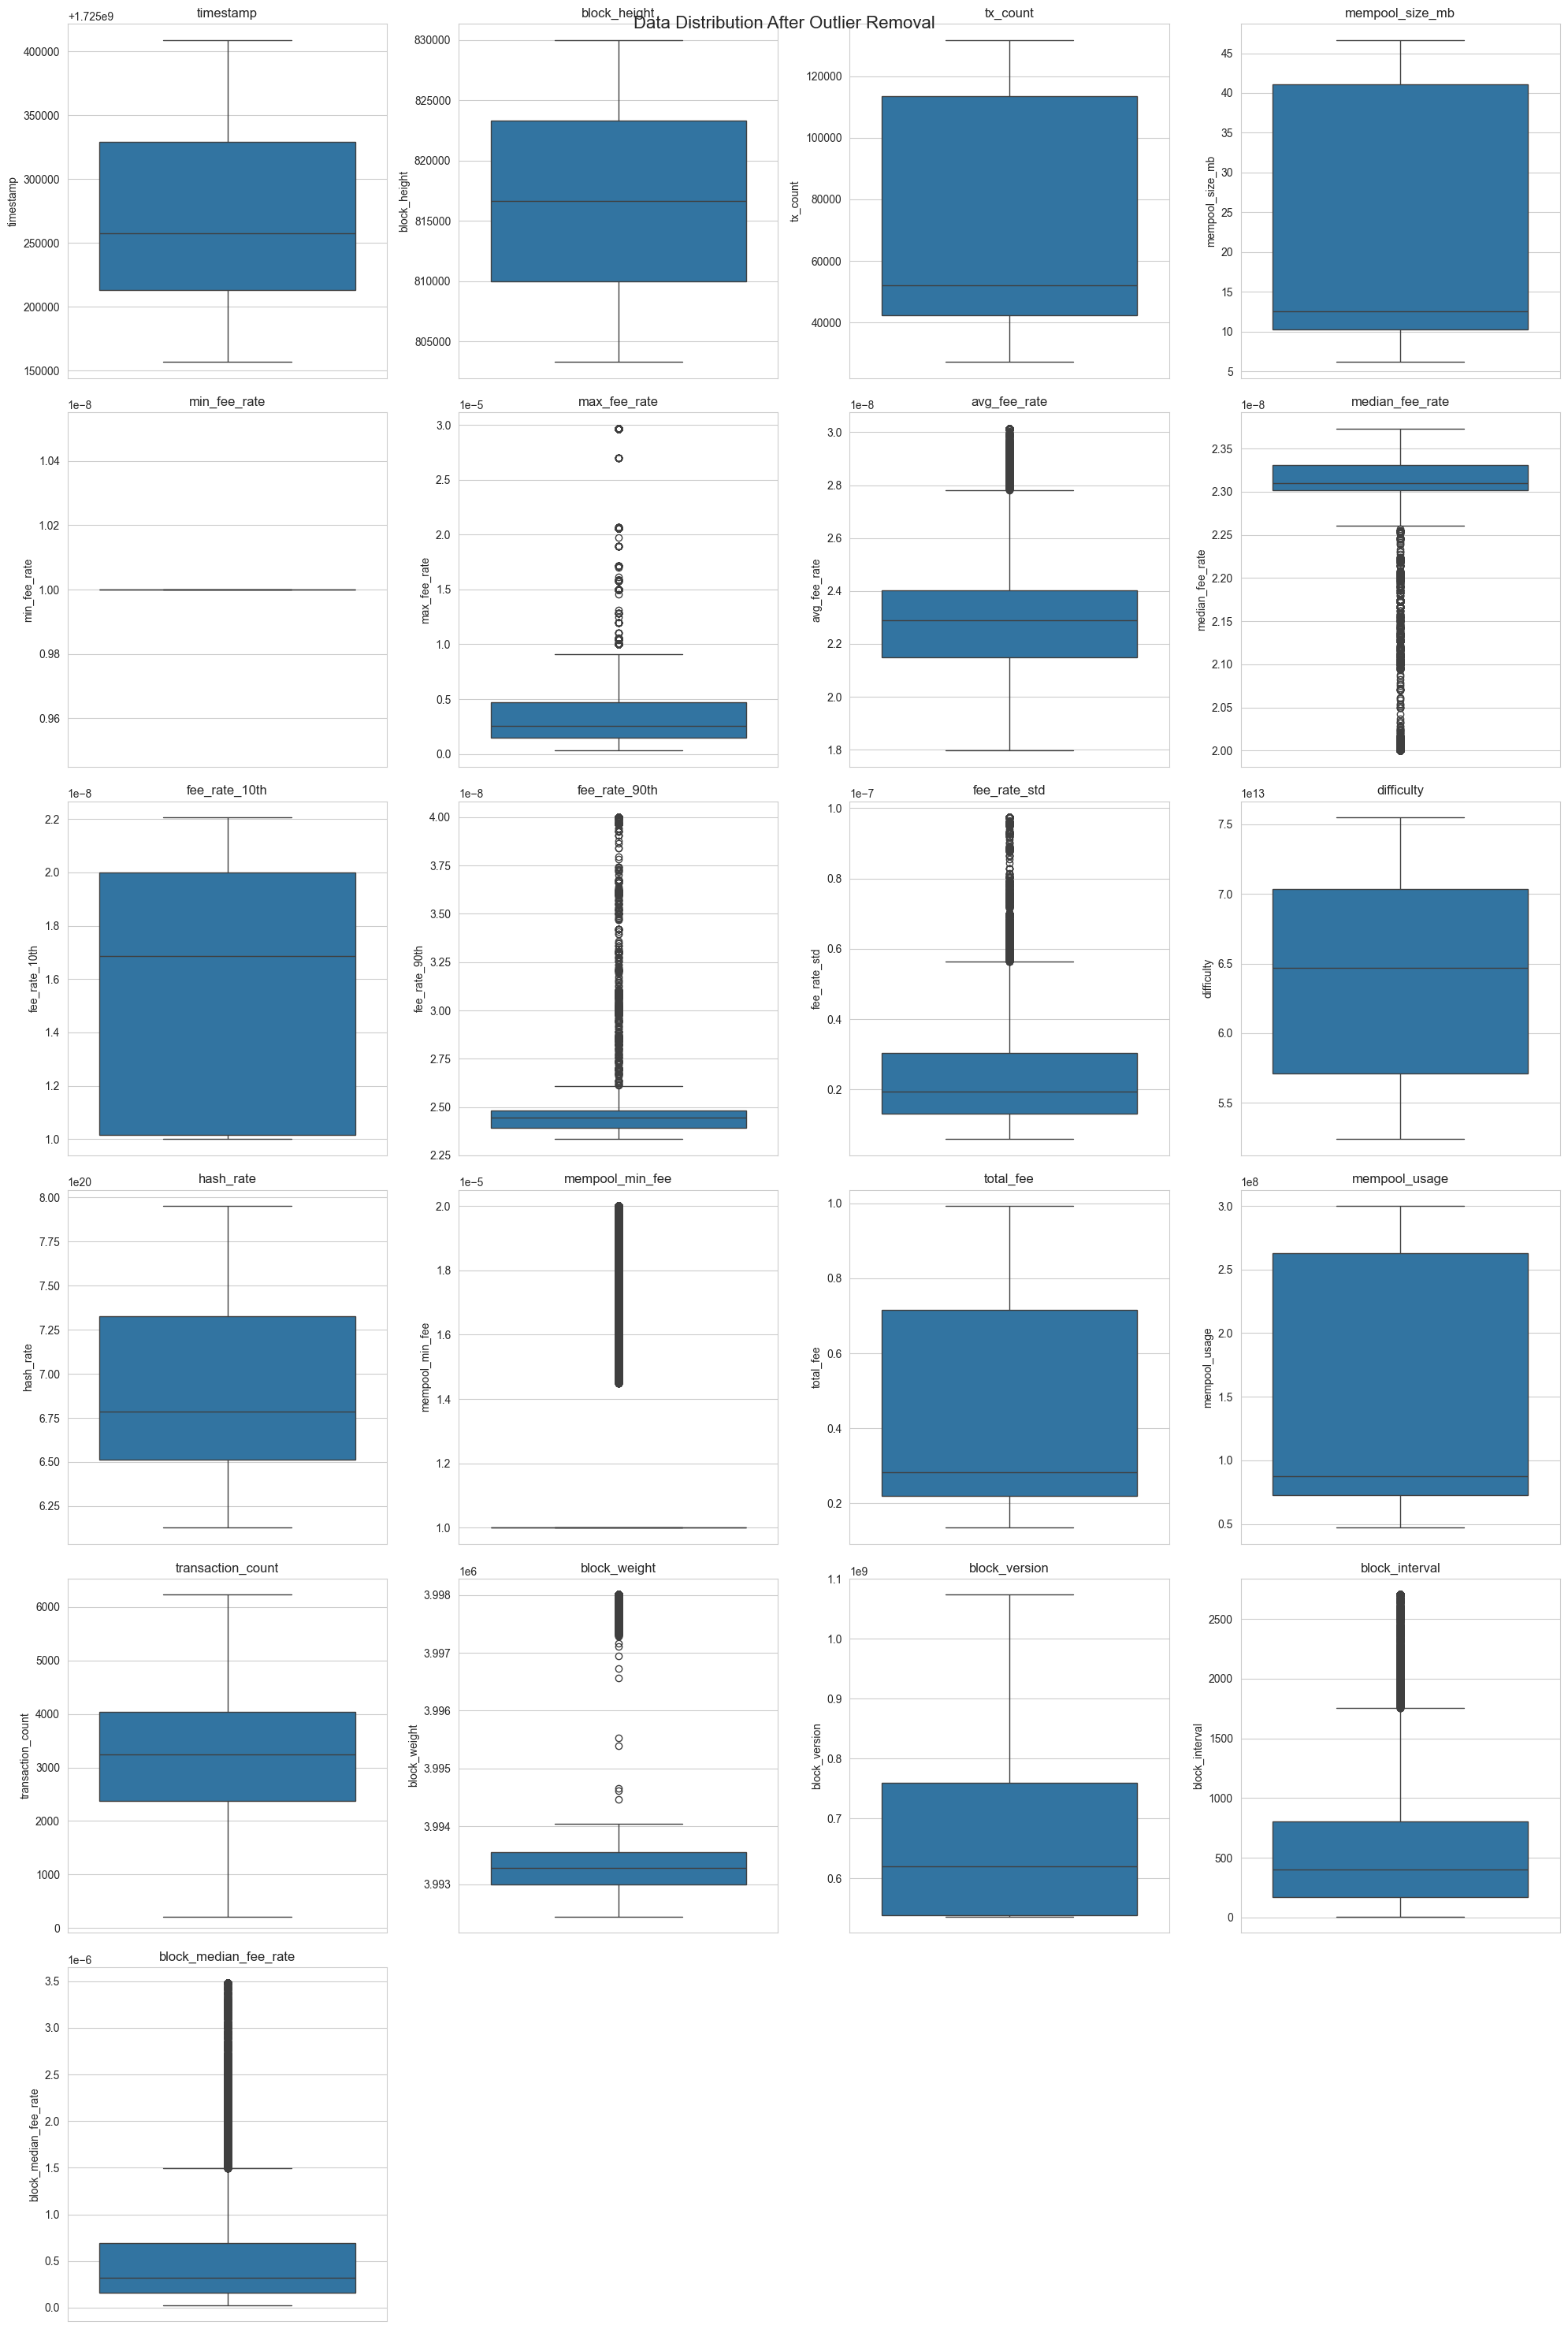

In [19]:
# Define a function to remove outliers by clipping based on percentiles
def handle_outliers(data, column, lower_percentile=1, upper_percentile=99):
    lower = np.percentile(data[column], lower_percentile)
    upper = np.percentile(data[column], upper_percentile)
    data[column] = data[column].clip(lower, upper)
    return data

# Remove outliers for all columns except for 'block_height', 'timestamp', and 'difficulty'
for column in df.columns:
    if column not in ['block_height', 'timestamp', 'difficulty']:  # Exclude these columns
        df_cleaned = handle_outliers(df, column)


plot_boxplots(df_cleaned, "Data Distribution After Outlier Removal")

In [20]:
df_cleaned.shape

(26700, 21)

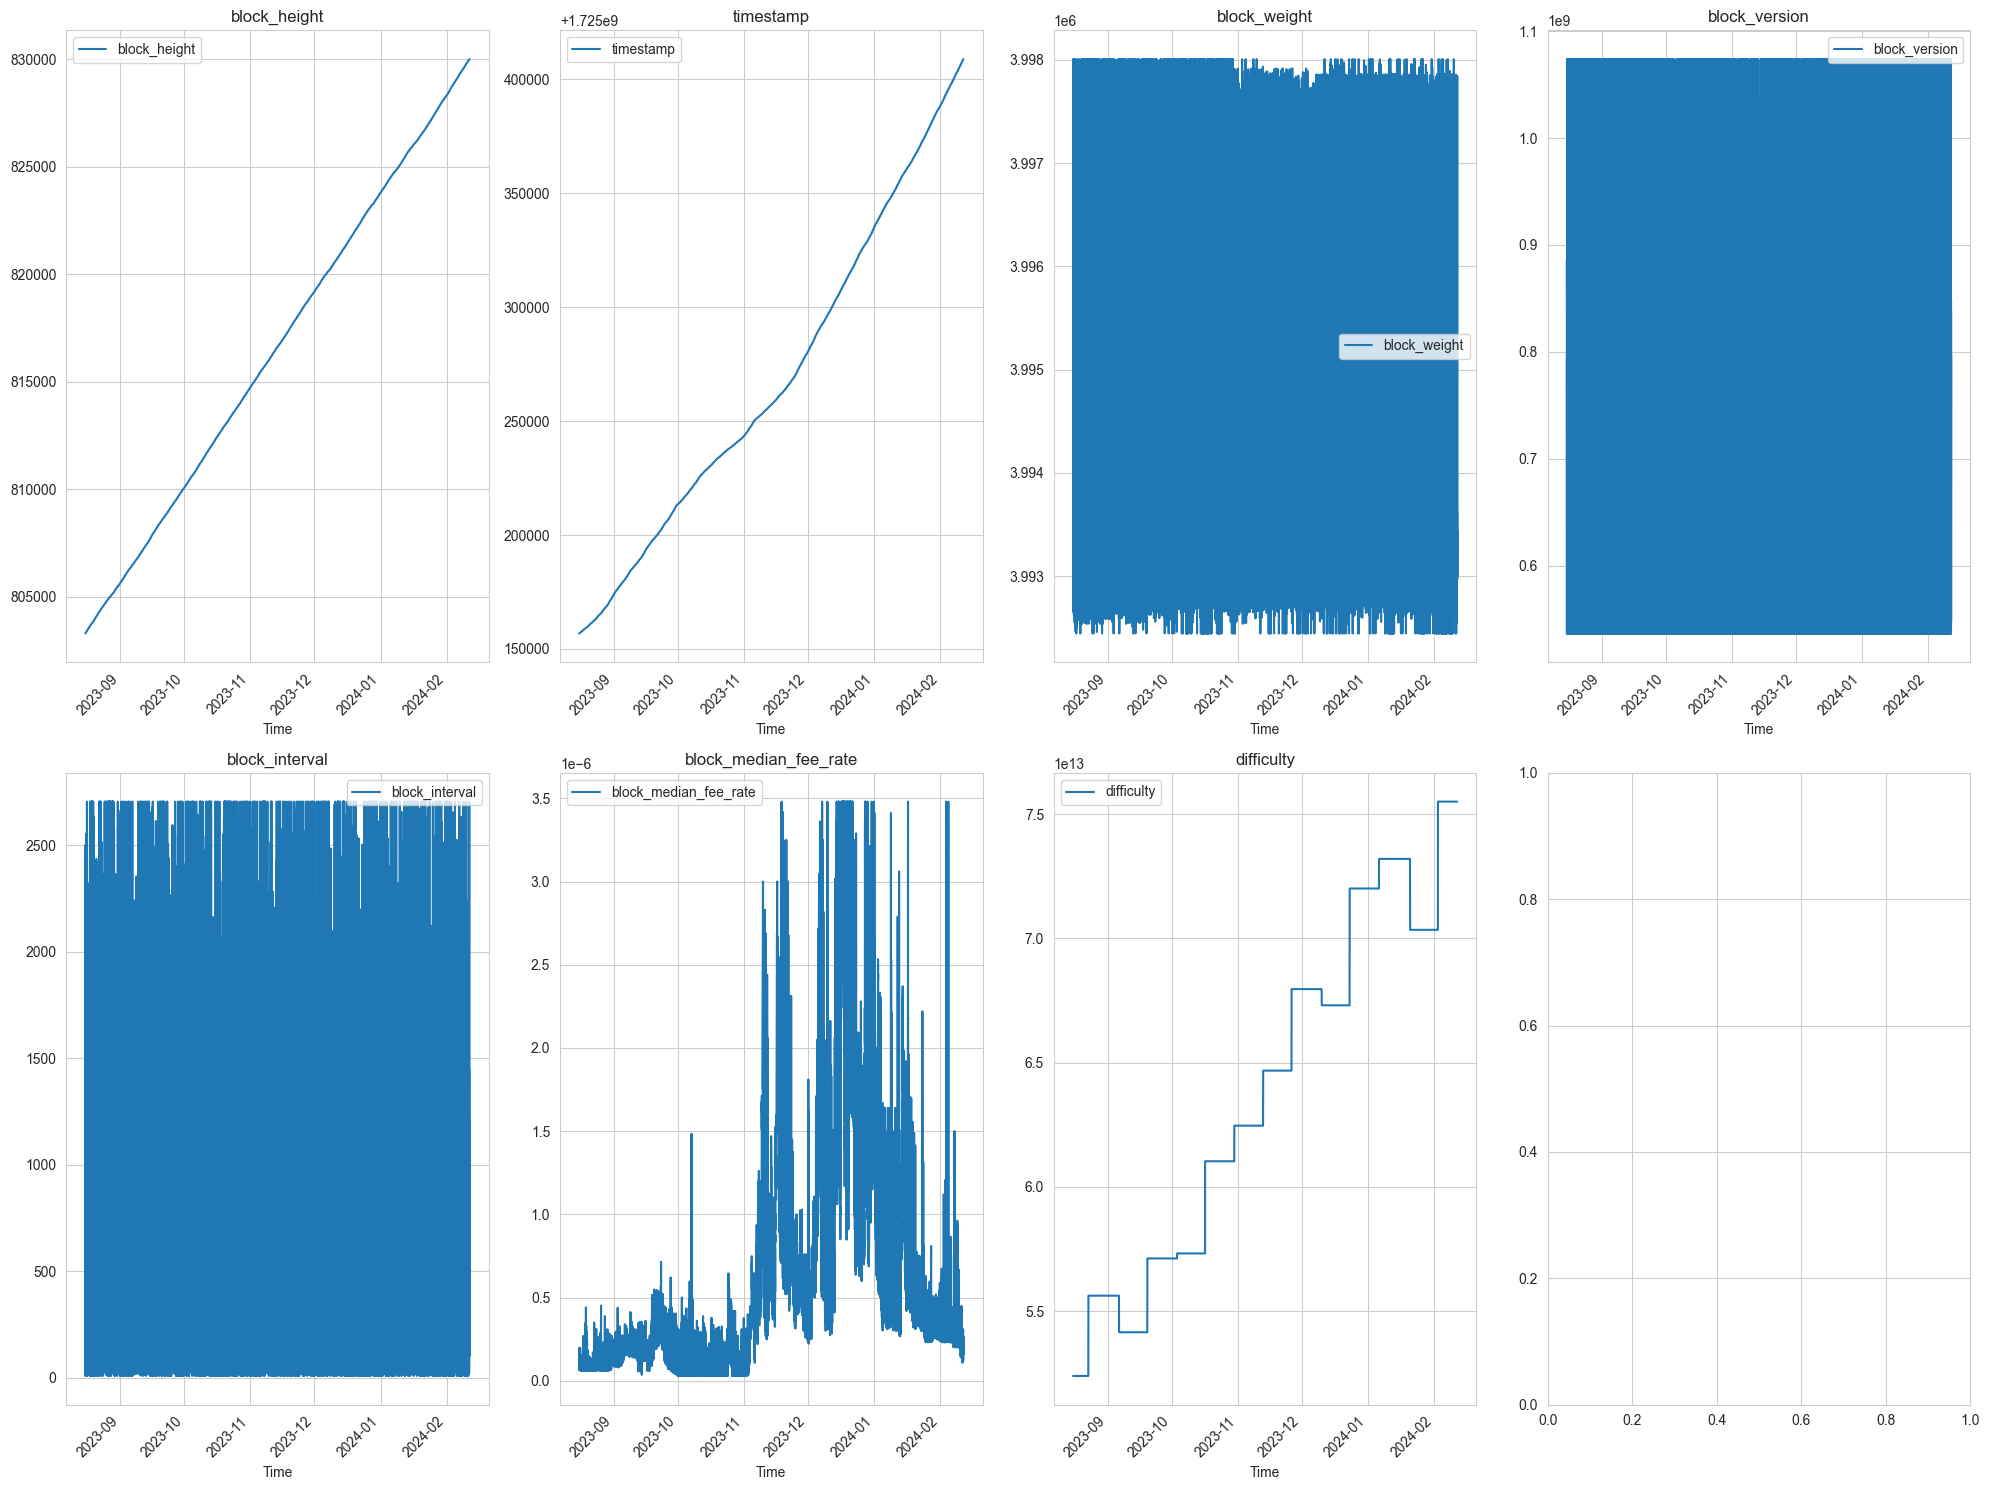

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_time_series(df, features, rows=3, cols=3, figsize=(20, 15)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() 
    
    for i, feature in enumerate(features):
        if i < len(axes) and feature in df.columns:
            ax = axes[i]
            df.plot(y=feature, ax=ax)
            ax.set_title(feature)
            ax.set_xlabel('Time')
            ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Update these lists based on the columns actually present in df_cleaned
block_features = ['block_height', 'timestamp', 'block_weight', 'block_version', 'block_interval','block_median_fee_rate','difficulty']
transaction_features = ['tx_count', 'transaction_count', 'total_fee']
fee_features = ['min_fee_rate', 'max_fee_rate', 'avg_fee_rate', 'median_fee_rate', 'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std', 'block_median_fee_rate']
mempool_features = ['mempool_size_mb', 'mempool_min_fee', 'mempool_usage']
network_features = ['difficulty', 'hash_rate']


plot_time_series(df_cleaned, block_features,rows=2, cols=4)

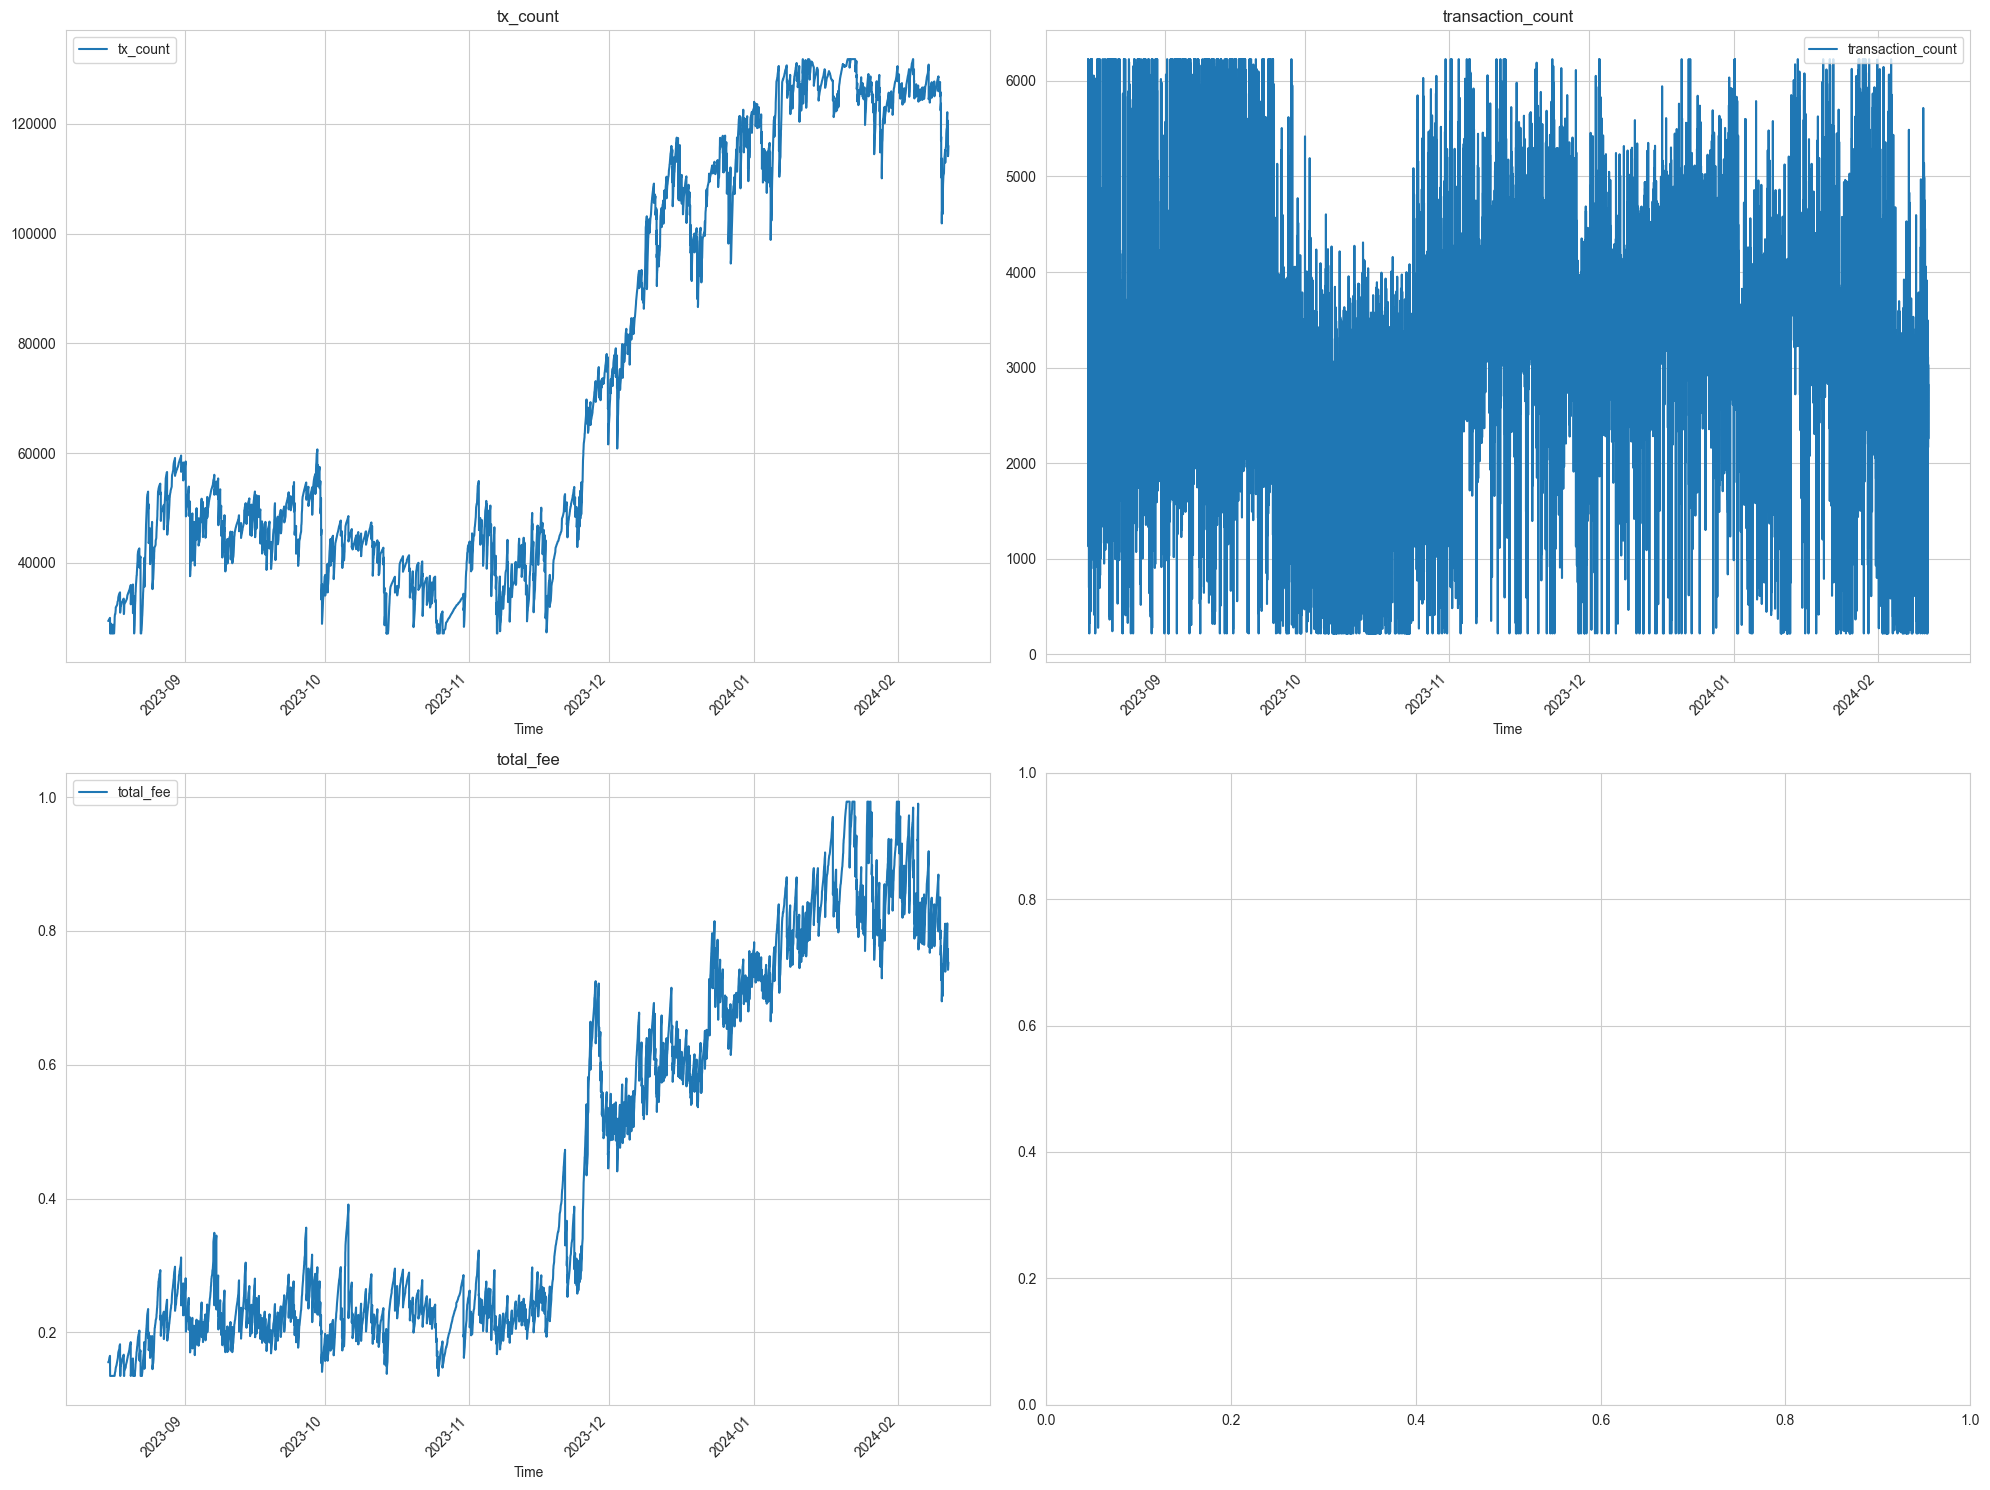

In [23]:
plot_time_series(df_cleaned, transaction_features,rows=2, cols=2)

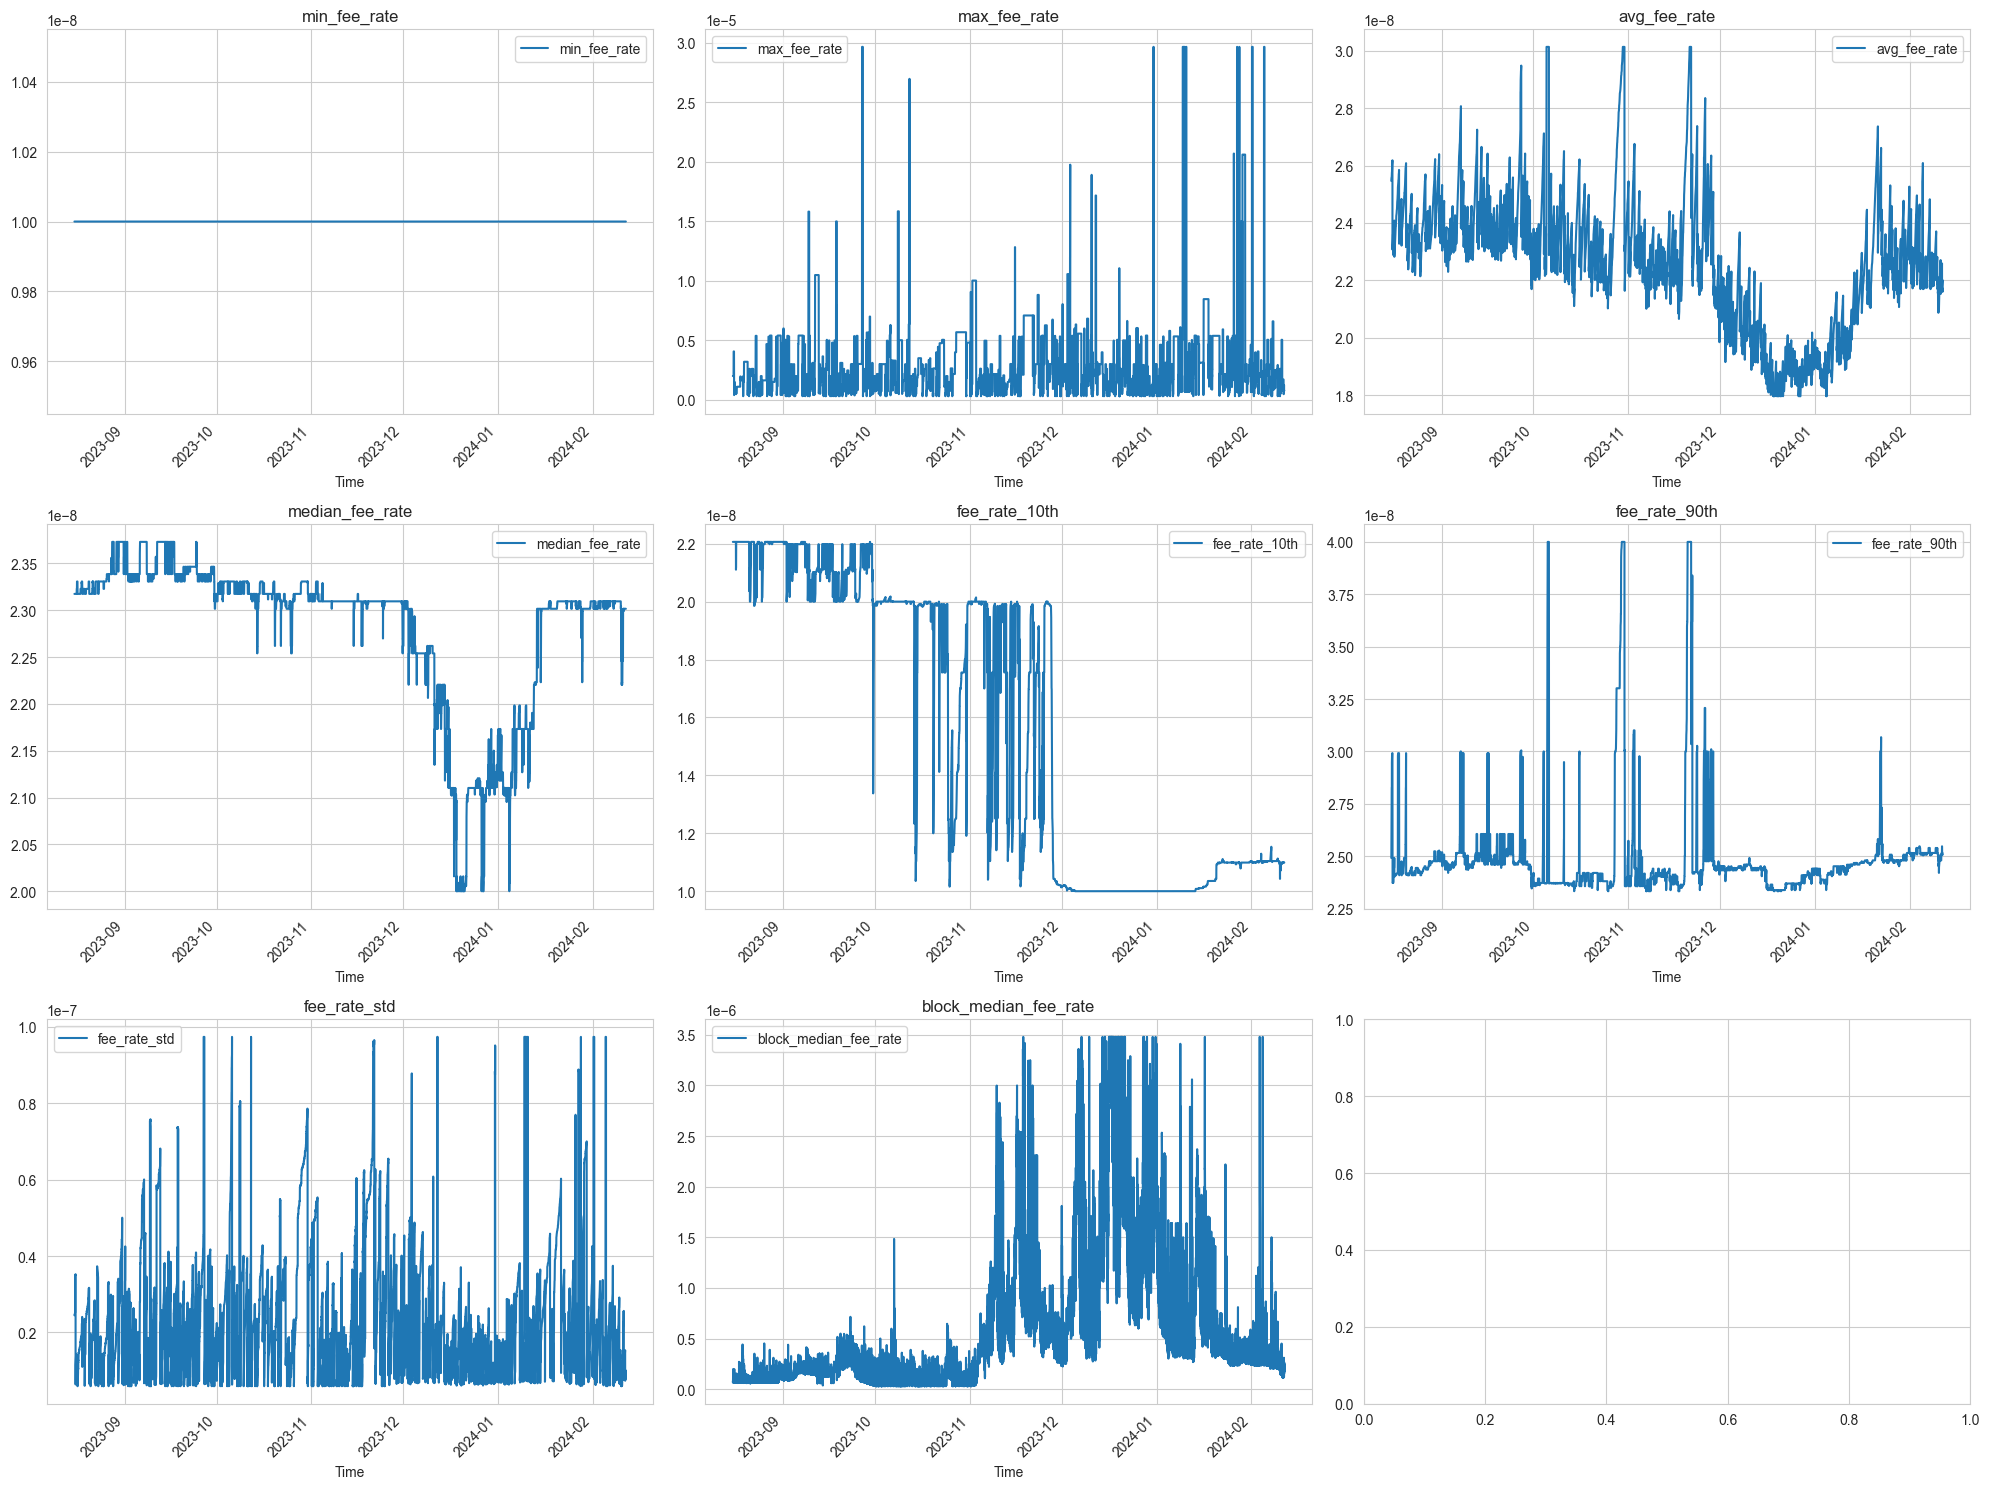

In [24]:
plot_time_series(df_cleaned, fee_features,rows=3, cols=3)

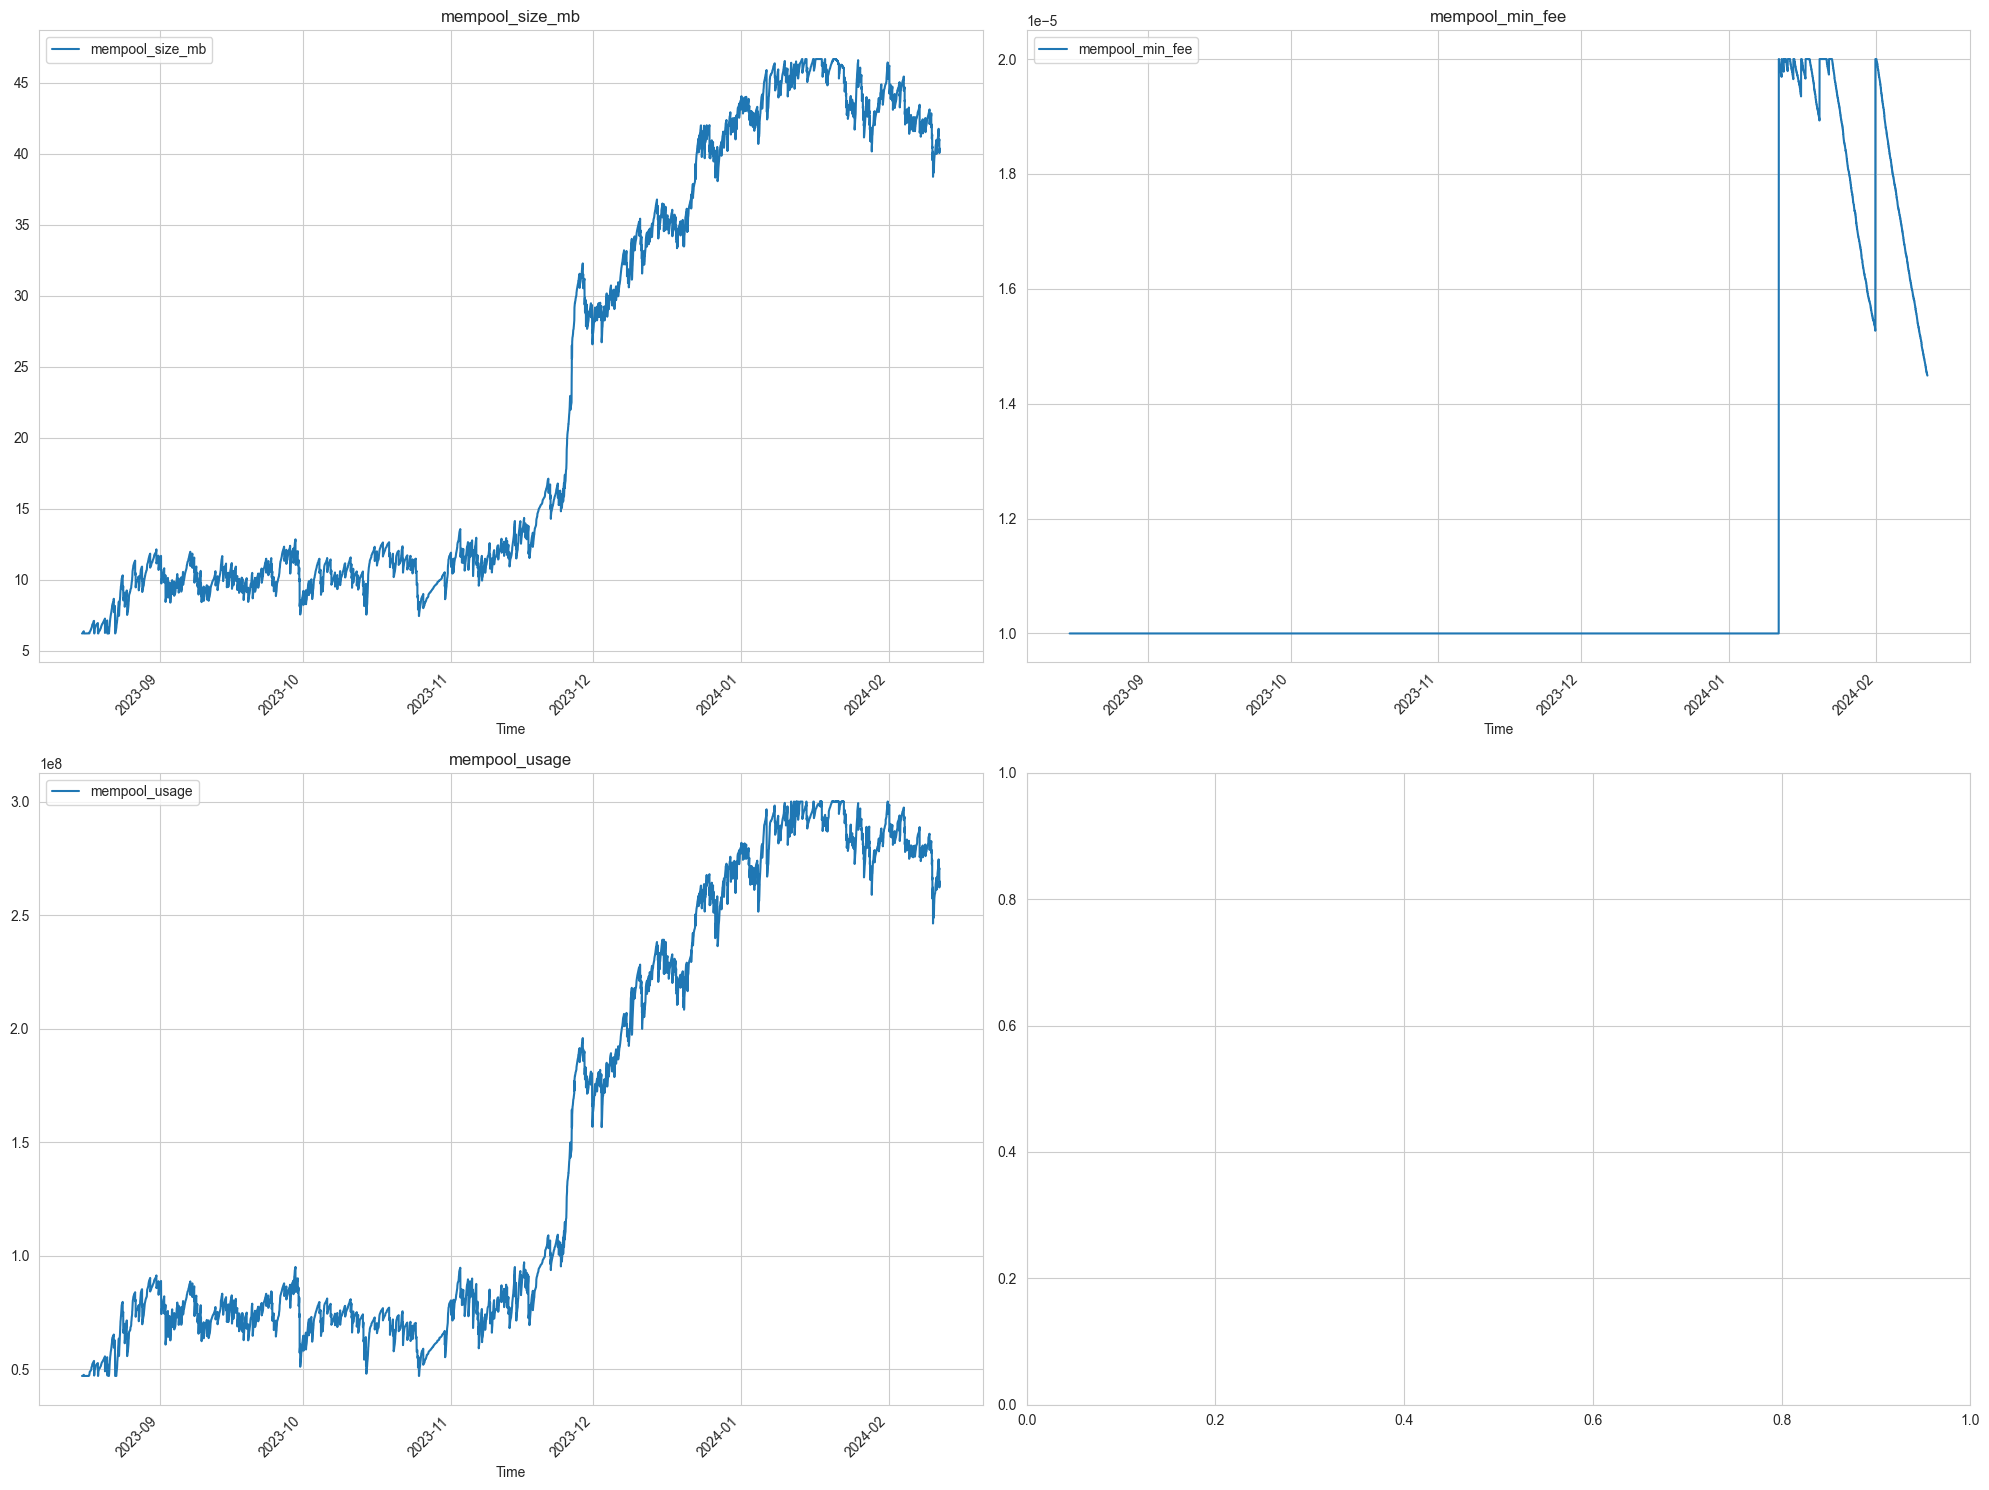

In [25]:
plot_time_series(df_cleaned, mempool_features,rows=2,cols=2)


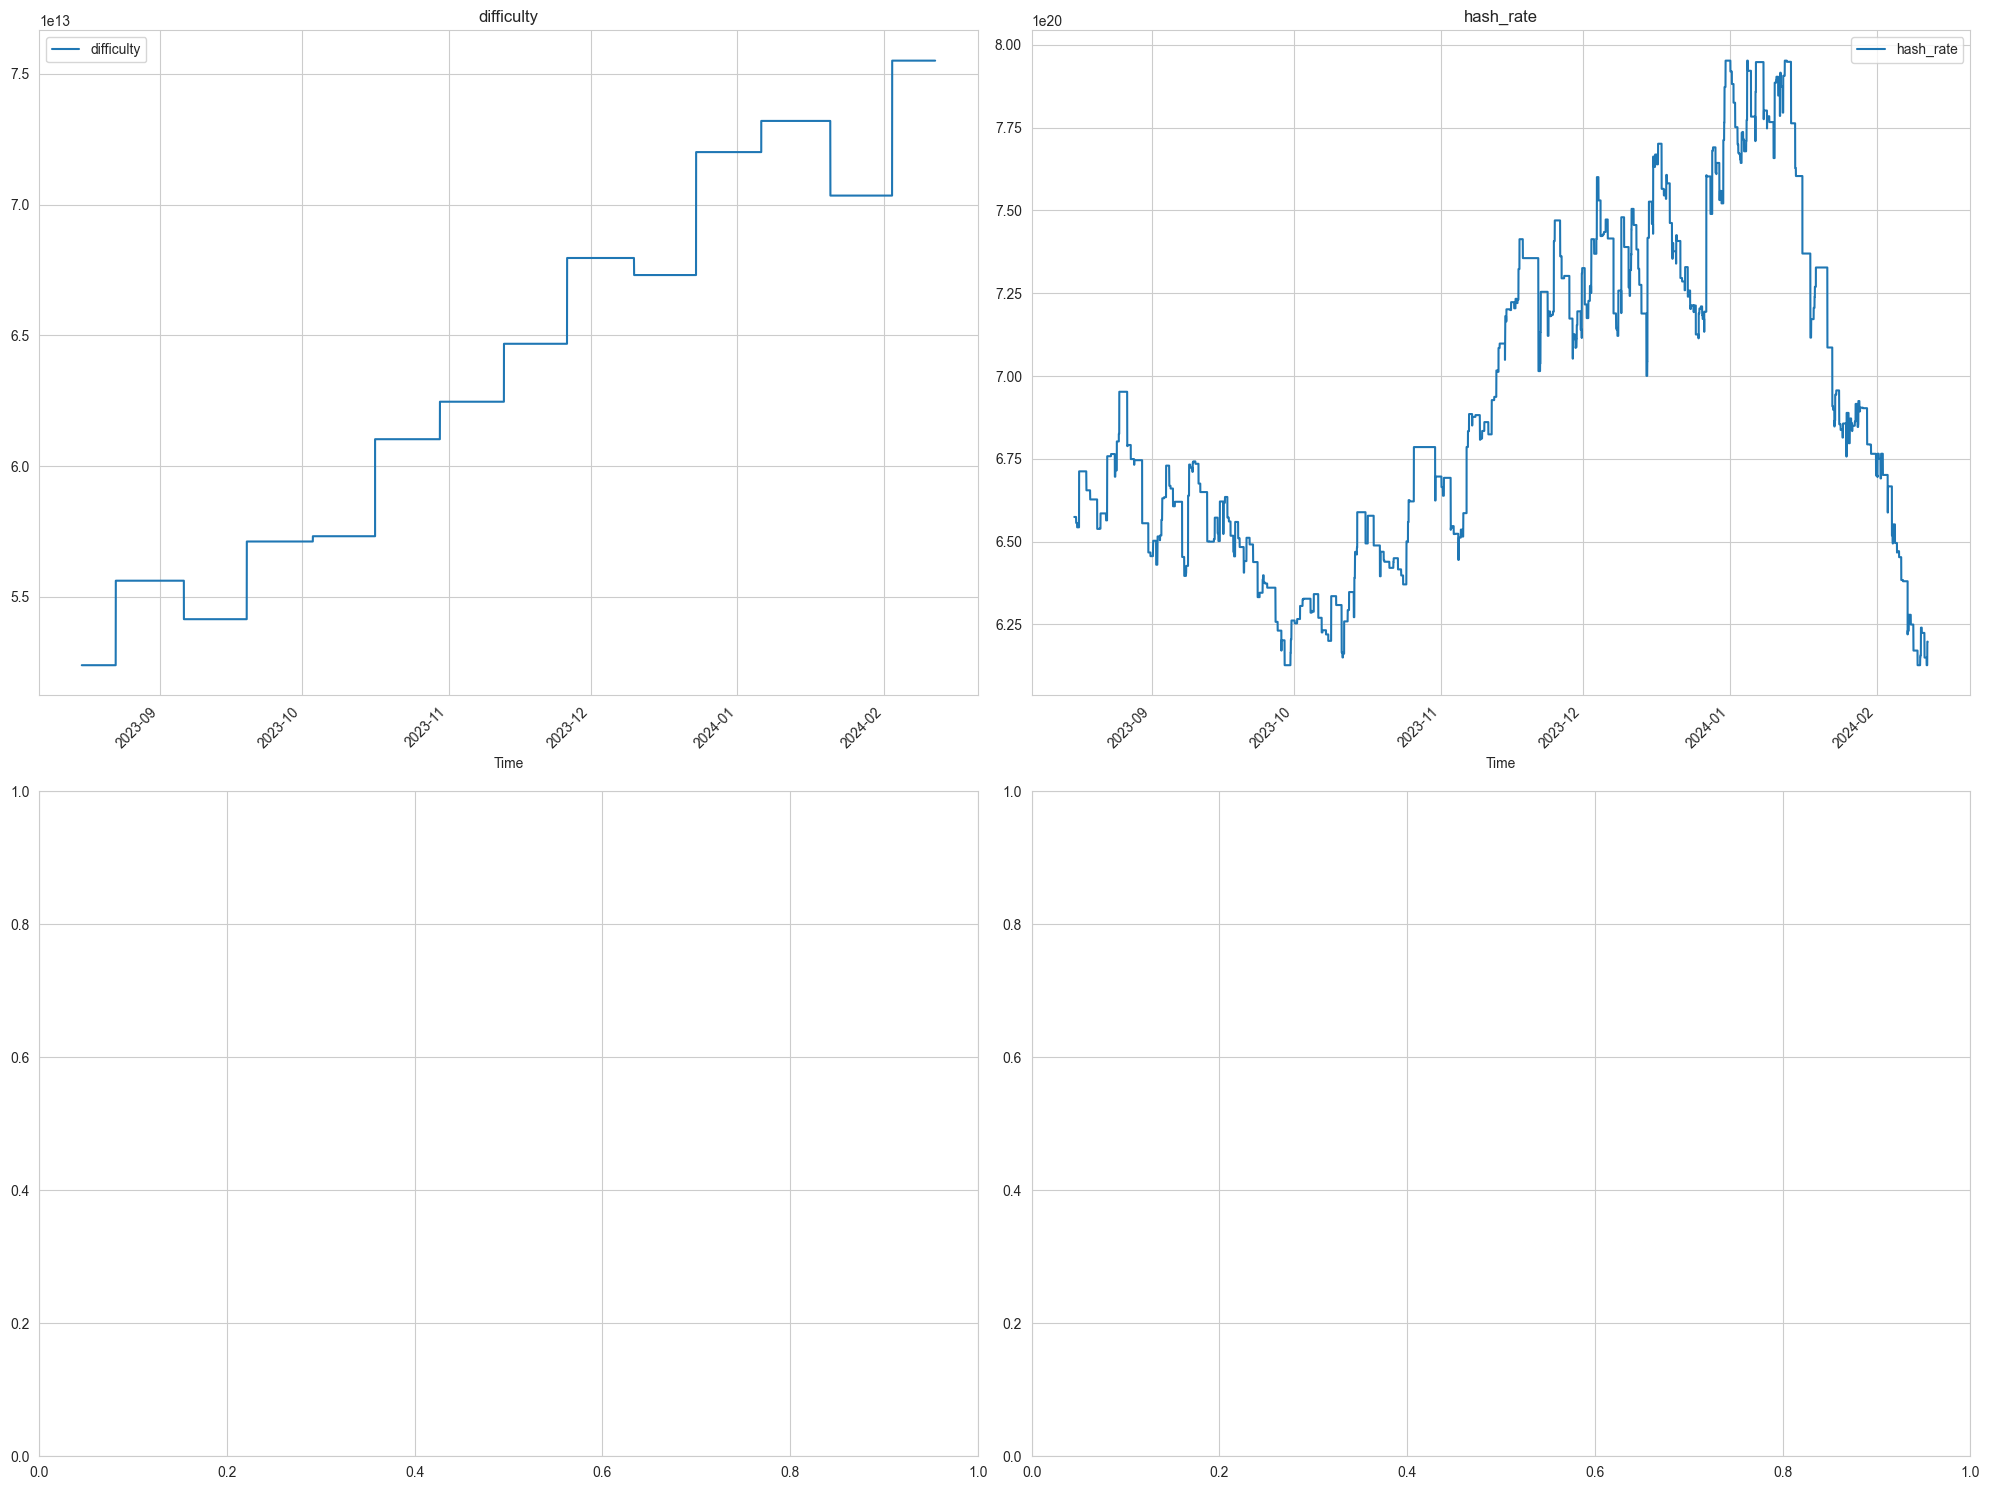

In [26]:

plot_time_series(df_cleaned, network_features, rows=2, cols=2)

Based on the above plots, I noticed that the features mempool_min_fee and min_fee_rate show little fluctuation, and the timestamp column is primarily used for debugging purposes. Therefore, I have decided to remove these three features and save the cleaned dataset for modeling.

In [27]:
df_cleaned.columns

Index(['timestamp', 'block_height', 'tx_count', 'mempool_size_mb',
       'min_fee_rate', 'max_fee_rate', 'avg_fee_rate', 'median_fee_rate',
       'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std', 'difficulty',
       'hash_rate', 'mempool_min_fee', 'total_fee', 'mempool_usage',
       'transaction_count', 'block_weight', 'block_version', 'block_interval',
       'block_median_fee_rate'],
      dtype='object')

In [29]:
df_cleaned=df_cleaned[['block_height', 'tx_count', 'mempool_size_mb', 'max_fee_rate', 'avg_fee_rate', 'median_fee_rate',
       'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std', 'difficulty',
       'hash_rate', 'total_fee', 'mempool_usage',
       'transaction_count', 'block_weight', 'block_version', 'block_interval',
       'block_median_fee_rate']]

In [30]:
df_cleaned.to_csv('bitcoin_history1_clean.csv')

In [32]:
df_cleaned

,block_height,tx_count,mempool_size_mb,max_fee_rate,avg_fee_rate,median_fee_rate,fee_rate_10th,fee_rate_90th,fee_rate_std,difficulty,hash_rate,total_fee,mempool_usage,transaction_count,block_weight,block_version,block_interval,block_median_fee_rate
block_time,,,,,,,,,,,,,,,,,,
2023-08-15 13:04:26,803299,29424.0,6.205224,2.000000e-06,2.546653e-08,2.317460e-08,2.206349e-08,2.492063e-08,2.449531e-08,5.239118e+13,6.574572e+20,0.155298,47014961.6,3401.00,3993402.0,793116672,405.0,8.000000e-08
2023-08-15 13:07:55,803300,29433.0,6.205224,2.000000e-06,2.547332e-08,2.317460e-08,2.206349e-08,2.492754e-08,2.449685e-08,5.239118e+13,6.574572e+20,0.155378,47014961.6,5048.00,3993409.0,557588480,209.0,6.397059e-08
2023-08-15 13:08:04,803301,29441.0,6.205224,2.000000e-06,2.547714e-08,2.317460e-08,2.206349e-08,2.500000e-08,2.449535e-08,5.239118e+13,6.574572e+20,0.155421,47014961.6,6228.03,3997929.0,536870912,9.0,6.345588e-08
2023-08-15 13:16:21,803302,29452.0,6.205224,2.000000e-06,2.548790e-08,2.317460e-08,2.206349e-08,2.500000e-08,2.451369e-08,5.239118e+13,6.574572e+20,0.155512,47014961.6,4308.00,3993126.0,783720448,497.0,6.389706e-08
2023-08-15 13:26:12,803303,29460.0,6.205224,2.000000e-06,2.550336e-08,2.317460e-08,2.206349e-08,2.500000e-08,2.456636e-08,5.239118e+13,6.574572e+20,0.155637,47014961.6,3335.00,3993490.0,830971904,591.0,7.059715e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-11 16:54:13,829994,114970.0,40.197975,7.765957e-07,2.166685e-08,2.301587e-08,1.098837e-08,2.507937e-08,8.380350e-09,7.550217e+13,6.198125e+20,0.747854,263447344.0,2171.00,3993477.0,849379328,570.0,2.000000e-07
2024-02-11 17:14:00,829995,115225.0,40.232427,7.765957e-07,2.167829e-08,2.301587e-08,1.098837e-08,2.507937e-08,8.432368e-09,7.550217e+13,6.198125e+20,0.748885,263766816.0,3031.00,3993059.0,797360128,1187.0,2.519905e-07
2024-02-11 17:24:07,829996,115399.0,40.257759,7.765957e-07,2.169418e-08,2.301587e-08,1.098837e-08,2.507937e-08,8.552873e-09,7.550217e+13,6.198125e+20,0.749860,263989824.0,2676.00,3993783.0,574103552,607.0,1.700000e-07


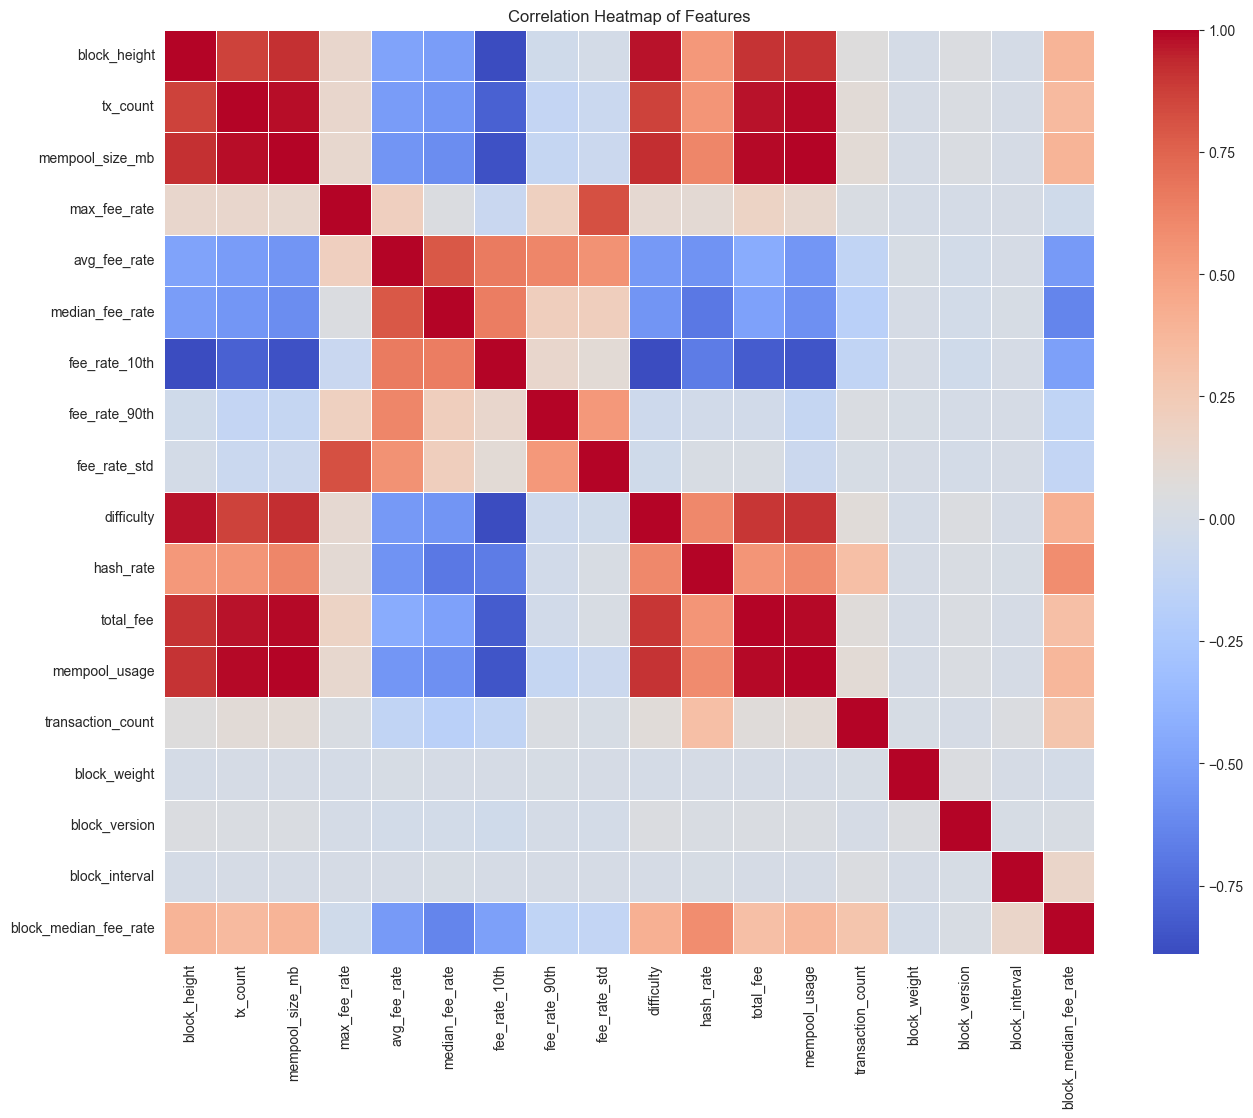

In [31]:
# Correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(df_cleaned.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

In [39]:
# Please ignore, just used for check real time data
pd.read_csv('real_time.csv')

,timestamp,block_height,tx_count,mempool_size_mb,min_fee_rate,max_fee_rate,avg_fee_rate,median_fee_rate,fee_rate_10th,fee_rate_90th,...,total_fee,mempool_usage,transaction_count,block_weight,block_version,block_interval,block_median_fee_rate,time_since_last_block,mempool_fee_histogram,bitcoin_price_usd
0,1726469858,861523,59716,51.68134,1.0,403.4234,1.8891,2.0068,1.0166,2.0794,...,82339680.0,292674144,4407,3993295,689364992,NaN,2.1032,NaN,"[59691, 10, 7, 1, 2, 1, 1, 2, 0, 1]",58657
1,1726470091,861524,57979,50.83073,1.0,14.2340,1.7086,2.0039,1.0160,2.0714,...,77637217.0,288180656,2292,3993188,838860800,989.0,4.0000,989.0,"[57633, 317, 15, 7, 2, 2, 1, 1, 0, 1]",58657
